# Images with a convnet: comparing architectures

In [1]:
# Disable GPU for now
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from random import randint

# Percolation data

To define some image data, we will consider small images, 8x8 in black and white (or 0 and 1). 

The first concept that we will try to teach a NN is whether there is a continuous path of "white" pixels between the two sides of the image.

The function `percolate` returns True is there is a continuous path between the left and right sides of a binary image. (Aspects of python that are used are sets, a while loop, and break. )  

In [4]:
def percolate( mat ):
    """
    Returns True if there is a percolation path of 1s from col 0 col -1 of a matrix of 0s and 1s
    """
    nrows = mat.shape[0]
    ncols = mat.shape[1]
    frontier = set()
    for i in range(0,nrows):
        if mat[i,0]:
            frontier.add( (i,0) )
    explored = set()
    flag = False # this will be returned if the frontier becomes empty without finding a
                 # filled pixel in the right-most column
    while frontier: # frontier evaluates to True in this context if it is non-empty
        r,c = frontier.pop()
        explored.add( (r,c) )
        if r > 0: # North
            if mat[r-1,c]:
                coords = (r-1,c)
                if coords not in explored: 
                    if coords not in frontier: # this order of testing is necessary since each element of explored has been in frontier
                        frontier.add( coords )
        if c < ncols-1: # East
            if mat[r,c+1]:
                if c+1 == mat.shape[1]-1 : # Hurray, we have percolated to the last column
                    flag = True
                    break
                coords = (r,c+1)
                if coords not in explored: 
                    if coords not in frontier: # this order of testing is necessary since each element of explored has been in frontier
                        frontier.add( coords )
        if r < nrows-1: # South
            if mat[r+1,c]:
                coords = (r+1,c)
                if coords not in explored: 
                    if coords not in frontier: # this order of testing is necessary since each element of explored has been in frontier
                        frontier.add( coords )
        if c > 0: # West
            if mat[r,c-1]:
                coords = (r,c-1)
                if coords not in explored: 
                    if coords not in frontier: # this order of testing is necessary since each element of explored has been in frontier
                        frontier.add( coords )
    return flag
        

Now test the percolate function. We will generate random images with a probability 0.6 probability of 1 in each pixel. 

(<matplotlib.image.AxesImage at 0x23e937a7848>, True)

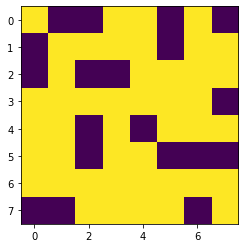

In [5]:
tmp = np.random.random([8,8]) > 0.4

plt.imshow(tmp), percolate(tmp)

# the first result is an image; the second result is True if there is a continuous path of yellow squares from the left to
# the right side of the image. The path is continuous if the yellow squares are joined at one side: two yellow squares 
# at a corner do not count as joined in a path

# you can evaluate this cell many times, and each time look at the resulting plot and answer, to check that you 
# understand the notion of percolation, and also that the `percolate` function is getting it right ! 

In [6]:
def make_percolation_dataset(side=8,threshold=0.42,n_examples=10):
    """
    This function generates an array of random images, in the form needed for Keras, and 
    then labels them as percolating or not, using the percolate function. Roughly 50% of the
    images will have class 1 (percolating), so the dataset is likely to be reasonably balanced. 
    """
    X_data = (np.random.random([n_examples,side,side,1]) > threshold).astype(float) 
    Y_data = np.zeros([n_examples,1])
    for i in range(0,n_examples):
        if percolate(X_data[i,:,:,0]):
            Y_data[i,0] = 1
    return (X_data,Y_data)
        

# Train with Keras

In [7]:
# the precise form of import statement needed will depend on the configuration 
# these import statements work successfully on my installation (Anaconda on iMac)
# the next cell gives import statements that (should hopefully) work on the machines in McCrea 103
import tensorflow.keras

In [8]:
# These import statements should work with the McCrea 103 installation of tensorflow and keras

from tensorflow.python.keras.layers import Input, Dense, Dropout, Flatten, Conv2D 
# you may also wish to import other layers - see the Keras documentation

from tensorflow.python.keras.models import Sequential

import tensorflow.python.keras.regularizers

Now construct a model and train it

In [9]:
# these work on my installation

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.regularizers import l1,l2

ModuleNotFoundError: No module named 'keras'

In [19]:
# these should work on the McCrea 103 installation

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras.regularizers import l1,l2

In [20]:
training_set,training_classes = make_percolation_dataset(side=8, threshold=0.42, n_examples=32000)
validation_set, validation_classes = make_percolation_dataset(side=8, threshold=0.42, n_examples=10000)

In [21]:
np.sum(training_classes)  # this gives the number of positive examples (percolated grids) in the training set
# should be close to half the size of the training set

15373.0

(<matplotlib.image.AxesImage at 0x23e9c381d88>, 1.0)

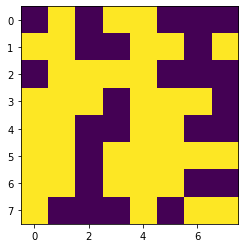

In [22]:
plt.imshow(training_set[376,:,:,0] ), training_classes[376,0]  # check a random element of the training set to see it is correct

# The Golden Rules of Model Search

Step 1: what error rate do you expect a good model to have?  (It may be zero, or there may be some residual error rate - perhaps even humans do not perform perfectly.) Call this error rate the *ideal error rate*

Step 2: define and fit a model and examine the training and validation errors. 

Step 3a: If the model does not fit the training set well, then the model does not have enough capacity (flexibility).  Add more complexity in some way  - more neurons, more layers. It is of course best to do this in an insightful way !  Go to step 2. 

Step 3b: If the model *does* fit the training set well, but there is higher error on the validation set, then the model is overfitted. Do either (or both)  of: 

    * Use more training data
    
    * Add more regularisation to the model (in an insightful way). 
    
Go to step 2. 


These golden rules are not very specific, but they are a lot better than simply making random changes to the model and hoping that it gets better. 



### A naive fully connected  Dense model for detecting percolation

(For tutorial purposes) the first thing to try is a naive model which pays no attention to the image structure. I don't expect this type of model to work well - but you may find a way to surprise me. 

In the model defined below, we flatten the image to a single row of values, and then we put in a single layer of neurons, each one of which is connected to all of the inputs. In other words, each neuron in this layer has 64 inputs, and then there is a final neuron which gives the output. 

You will (I hope) find that this is a terrible architecture for this problem. You will find that if there are too few neurons, then the model cannot even fit the training data.  If there are too many neurons in the Dense layer, then the model will fit the training data, but fail almost completely on the validation data: that is, the model will overfit badly. 

What would be the only way to get this poorly designed model to work? *Use a lot of training data!* . You can try constructing a much larger training set, and then see if you can get this model to classify correctly.  I doubt it - but you might succeed. 

Does adding more dense layers help?  Does adding regularisation - either `l1`, `l2`, or dropout - help? 

In [13]:
model_dense = Sequential()
model_dense.add(Flatten(input_shape=(8,8,1))) # converts each image to a 1D array of values
model_dense.add(Dense(300,activation='relu'))
model_dense.add(Dense(1,activation='sigmoid'))

You can try numbers of hidden units ranging from 10 to 1000; you can try multiple layers (but with less than 100 neurons per layer - connecting a layer with 1000 neurons to another with 1000 neurons needs a million weights, which is too many for the CPU to handle in a reasonabe time.)

In [14]:
model_dense.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 300)               19500     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 19,801
Trainable params: 19,801
Non-trainable params: 0
_________________________________________________________________


The model summary above shows you the shapes of each layer and how many trainable weights there are.  This is helpful in checking that the structure of your model is what you intended. 

In [15]:
model_dense.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

Start off with a small number of epochs - 2,say! you can then figure out how long a longer training will take. 

In [16]:
history = model_dense.fit(training_set,training_classes,
                          batch_size=32,epochs=20,shuffle=True,verbose=1, 
                          validation_data=(validation_set, validation_classes))

Train on 32000 samples, validate on 10000 samples
Epoch 1/20
32000/32000 [==============================] - 2s 53us/sample - loss: 0.6190 - accuracy: 0.6566 - val_loss: 0.5568 - val_accuracy: 0.7251
Epoch 2/20
32000/32000 [==============================] - 1s 39us/sample - loss: 0.5388 - accuracy: 0.7290 - val_loss: 0.5182 - val_accuracy: 0.7433
Epoch 3/20
32000/32000 [==============================] - 1s 39us/sample - loss: 0.5041 - accuracy: 0.7511 - val_loss: 0.5127 - val_accuracy: 0.7420
Epoch 4/20
32000/32000 [==============================] - 1s 38us/sample - loss: 0.4880 - accuracy: 0.7581 - val_loss: 0.5030 - val_accuracy: 0.7502
Epoch 5/20
32000/32000 [==============================] - 1s 36us/sample - loss: 0.4732 - accuracy: 0.7705 - val_loss: 0.4965 - val_accuracy: 0.7561
Epoch 6/20
32000/32000 [==============================] - 1s 40us/sample - loss: 0.4569 - accuracy: 0.7816 - val_loss: 0.4909 - val_accuracy: 0.7589
Epoch 7/20
32000/32000 [==============================] 

See below for how to examine the structure of the history, and to plot curves of loss and accuracy during training for both the training and validation data. 

### A convolutional model for detecting percolation

Since percolation depends on local properties of the image, a better strategy may be to used a convolutional model, like the one defined below. 

After some messing about, I found that the model defined has reasonable (but not perfect) performance.  Please try to find a better one ! I was a little disappointed that I found that max-pooling layers seemed to slightly reduce performance, but you might find differently.  

Perhaps some 1x1 convolutions might improve performance?  I haven't tried them. 

Your challenge is to try this model out, and then to do some experiments. (To do experiments, you will need to be tidy: I suggest  

* For a small training set size (say 1000) examine the effect of different types and levels of regularisation. Try putting in `l1` and `l2` regularisation, and dropout (try each separately). 
    When adding `l1` or `l2` regularisation, a reasonable amount to add is in the region of 
    0.00001 to 0.001 .  Larger amounts of regularisation will just force all the weights towards zero. 

* How does validation error vary with training set size?  This is an important question!  Plot  log validation error versus  log training set size, in the range from 100 to 32000 (or 100000 if you have the time)  Plot a log-log graph, and see if you can identify a power law, visible as a straight(ish) line on the graph.  



In [23]:
model = Sequential()
model.add(Conv2D(36,(3,3),activation='relu',padding='same',input_shape=(8,8,1), kernel_regularizer=l1(0.000)))
model.add(Conv2D(36,(1,1),activation='relu',padding='same', kernel_regularizer=l1(0.0001)))
#model.add(Dropout(0.1))
model.add(Conv2D(48,(3,3),activation='relu',padding='valid', kernel_regularizer=l1(0.0001))) # reduces the grid size to 6x6
model.add(Dropout(0.25))
model.add(Conv2D(48,(3,3),activation='relu',padding='valid', kernel_regularizer=l1(0.0001))) # reduces the grid size to 4x4
model.add(Dropout(0.25))
model.add(Conv2D(96,(3,3),activation='relu',padding='valid', kernel_regularizer=l1(0.0001))) # reduces the grid size to 2x2
model.add(Dropout(0.25))
model.add(Flatten()) # transforms layout to all 4x36=144 neurons to a line
model.add(Dense(20,activation='relu',kernel_regularizer=l2(0.00001)))  # 20 neurons each connected to all 144 previous neurons
model.add(Dense(20,activation='relu',kernel_regularizer=l2(0.00001)))  # 20 neurons each connsected to all 20 previous neurons
model.add(Dense(1,activation='sigmoid')) 
# one single logistic output neuron giving estimated probability of percolation


In [24]:
 model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 8, 36)          360       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 36)          1332      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 48)          15600     
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 48)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 48)          20784     
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 48)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 96)         

In [25]:
# I have found the 'adam' optimiser to work rather well for this problem, but you might like to try a simpler 
# gradient descent method. The learning rate may be a little high. 
sgd = SGD(lr=0.01, decay=1e-6,momentum=0.9, nesterov=True)

In [26]:
train_size = 5


In [27]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [28]:
history = model.fit(training_set[:train_size,:,:,:],training_classes[:train_size,:],
                          batch_size=5,epochs=2,shuffle=True,verbose=0, 
                          validation_data=(validation_set, validation_classes))

In [29]:
res = model.evaluate(validation_set,validation_classes,batch_size=32)
res

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.0015636323928834, 0.4821]

In [30]:
res = model.evaluate(training_set[:train_size,:,:,:],training_classes[:train_size,:],batch_size=32)
res

5/1 [======================================================================================================================================================] - 0s 593us/sample - loss: 0.9998 - accuracy: 0.8000


[0.9997934699058533, 0.8]

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

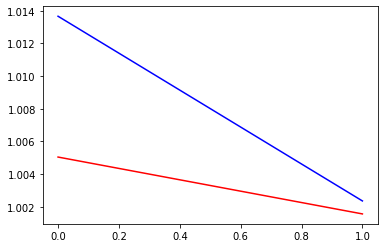

In [32]:
plt.plot(history.history['loss'],'b')
plt.plot(history.history['val_loss'],'r')

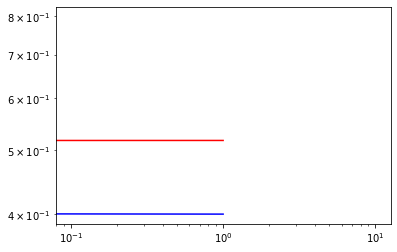

In [33]:
# good to use a log vertical scale here? 

plt.loglog(1 - np.array(history.history['accuracy']),'b')
plt.loglog(1 - np.array(history.history['val_accuracy']),'r')

### Power law for convolutional model 

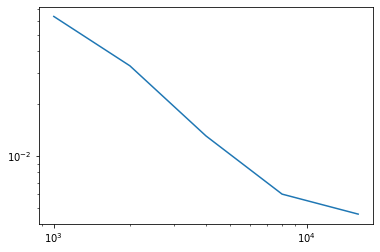

In [34]:
# actually plot the training set size vs validation error
# these are actual error-rates with the above Sequential convolutional model 
plt.loglog([1000,2000,4000,8000,16000], [0.0636,0.0330,0.0130,0.006,0.0046])

# Resnet model for percolation


In [35]:
from keras import Model
from keras.layers import Input, Conv2D, Add

In [36]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, Add

In [37]:
input1 = Input(shape=(8,8,1))

In [38]:
def conv_resnet_layer(inputs, n_convolutions, kernel_size, activation='relu', padding='same'):
    resnet1 = Conv2D(n_convolutions,kernel_size,activation=activation,padding=padding)(inputs)
    resnet2 = Conv2D(n_convolutions,kernel_size,activation=activation,padding=padding)(resnet1)
    resnet1_out = Add()([inputs, resnet1])
    return resnet1_out

In [39]:
resnet1 = conv_resnet_layer(input1, 12,(3,3))

In [40]:
type(resnet1)

tensorflow.python.framework.ops.Tensor

In [41]:
resnet2 = conv_resnet_layer(resnet1,12,(3,3))

In [42]:
resnet3 = conv_resnet_layer(resnet2,12,(3,3))

# Inspection of validation errors

In [44]:
np.sum(validation_classes)

4803.0

In [45]:
# should convert this to be a function taking the model and validation set as arguments 

validation_predictions = model.predict( validation_set )
validation_predicted_classes = (validation_predictions > 0.5).astype(float)
validation_errors_0_predicted_as_1 = validation_predicted_classes > validation_classes
validation_errors_1_predicted_as_0 = validation_predicted_classes < validation_classes

nfalse_positives, n_false_negatives = np.sum( validation_errors_0_predicted_as_1), np.sum( validation_errors_1_predicted_as_0 )

nfalse_positives, n_false_negatives

(4383, 796)

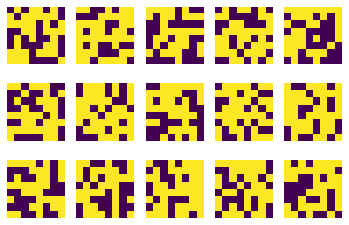

In [46]:
error_indices = np.where(validation_errors_1_predicted_as_0)[0]

fig,ax = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(min(15, n_false_negatives)):
    ax[i].imshow( validation_set[ error_indices[i],:,:,0])
    ax[i].axis('off')   

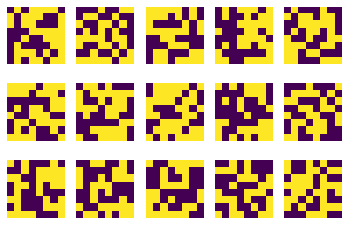

In [47]:
error_indices = np.where(validation_errors_0_predicted_as_1)[0]

fig,ax = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(min(15, n_false_negatives)):
    ax[i].imshow( validation_set[ error_indices[i],:,:,0])
    ax[i].axis('off')

# Getting inside the model and examining the weights

This week we will examine the model weights, and the effects of different types of regularisation on the distribution of weights. 

(Next week we will look at activations and gradients.)



## What can we find out by looking at the weights? 

You might (naively) hope to understand how the network works by examining the weights !  For this problem, that will be hard. (For the "blob" data, it may be easier.  For vision networks for natural images, it may *seem* easier still, although the detail of how the network functions may still be ineffable. ) 

However, we can see some important effects: we can examine the effect of different types of regularisation on the weights. 

* L2 regularisation (sum of squares) will tend to reduce the number of very large weights, and should reduce the RMS weight size

* L1 regularisation (sum of absolute weight values) will tend to make the weights more sparse, and many weights may be close to or equal to zero

* Dropout may act in a similar way to L2 regularisation

Levels of regularisation can be set for each layer individually: to looking at the distributions of weights in each layer may give an indication of where either more or less regularisation is needed. 

In [48]:
model # this is the model we have just trained.  
# In Python terms, it is just a variable with the name 'model', of type keras.models.Sequential

The `keras.models.Sequential` class is quite complicated, but we can get the different layers of the model (each layer is another keras class), and within each layer we can extract the weights. 

In [49]:
model.layers

In [50]:
layer_0 = model.layers[0] 
layer_0

In [51]:
weights_layer_0 = layer_0.get_weights()

In [52]:
type(weights_layer_0)

list

There are two elements in the list: the second is the biases (which were initialised to zero)

You should also examine these

In [53]:
weights_0 = weights_layer_0[0]
weights_0.shape

(3, 3, 1, 36)

Plot a histogram of the first layer weights

Can you extend this to a plot of histograms of weights in all the convolutional layers? 



(array([38., 40., 37., 27., 26., 34., 30., 33., 31., 28.]),
 array([-0.1356424 , -0.10847212, -0.08130183, -0.05413155, -0.02696127,
         0.00020901,  0.02737929,  0.05454957,  0.08171985,  0.10889014,
         0.13606042], dtype=float32),
 <a list of 10 Patch objects>)

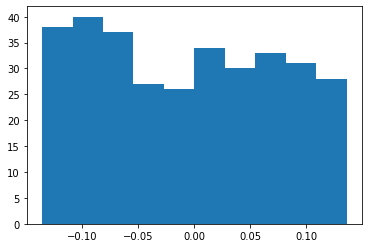

In [54]:
plt.hist(weights_0.flatten())

#### Self-help exercise

Extend the graph above to produce an array of histograms of the weight values of all layers. 

You can do this either by examining how I produced an array of heatmaps to show mis-classified examples, or else by looking at the `matplotlib` documentation and finding out how to produce `subplots`.  This is a basic skill, which you need to know. 

## Heatmaps of weights

Now plot the layer 1 weights as heatmaps: we will have to put them into one big matrix 
    
There are 36 3x3 weight matrices; we will put them in an 18x18 heatmap, and see if there are any obvious patterns...

Actually, it is better to allow rows and columns of zeros between the weights, so that each 3x3 group of weights stands out better, so we will use a 23x23 matrix

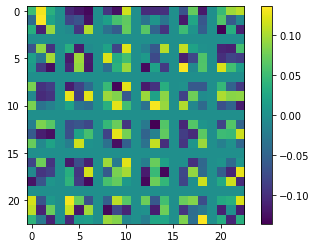

In [55]:
layer_1_heatmap  = np.zeros([23,23])

for rowx in range(6):
    for colx in range(6):
        weightx = colx + 6 * rowx 
        w = weights_0[:,:,0,weightx]
        layer_1_heatmap[rowx*4:rowx*4+3, colx*4:colx*4+3] = w

plt.imshow(layer_1_heatmap)
plt.colorbar()

If your heatmap is like mine, there are few obvious patterns and it is hard to see how the network might function!

The only insight that jumps is that (without regularisation) some groups of weights are all close to zero, and may not be used much - but it is difficult to tell, because the weights connected to them in the next layer might be larger!

For the "blob" data, you may find that the weights are more interpretable...

# Test examples for percolation


In [56]:
test_all_zeros = np.zeros([8,8])
#plt.imshow(test_all_zeros)
#plt.colorbar()

In [57]:
test_all_ones = np.ones([8,8])
#plt.imshow(test_all_ones)
#plt.colorbar()

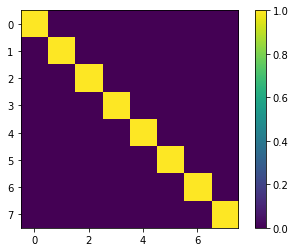

In [58]:
test_eye = np.eye(8) # this should be an easy example
plt.imshow(test_eye)
plt.colorbar()

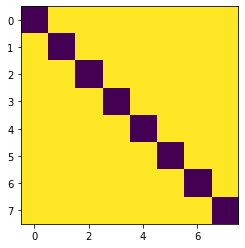

In [59]:
test_inverse_eye = 1 - np.eye(8)
plt.imshow( test_inverse_eye )

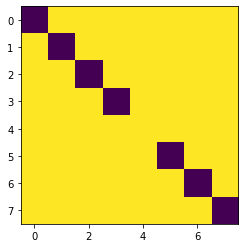

In [60]:
test_inverse_eye_connected = 1 - np.eye(8)
test_inverse_eye_connected[4,4] = 1
plt.imshow( test_inverse_eye_connected )

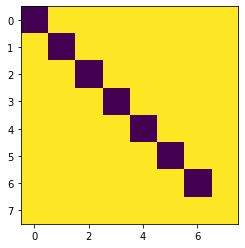

In [61]:
test_inverse_eye_connected_bottom = 1 - np.eye(8)
test_inverse_eye_connected_bottom[7,7] = 1
plt.imshow( test_inverse_eye_connected_bottom )

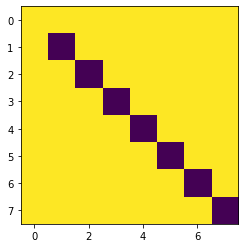

In [62]:
test_inverse_eye_connected_top = 1 - np.eye(8)
test_inverse_eye_connected_top[0,0] = 1
plt.imshow( test_inverse_eye_connected_top )

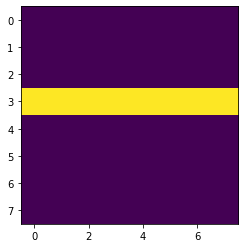

In [63]:
test_middle_row = np.zeros([8,8])
test_middle_row[3,:] = 1
plt.imshow(test_middle_row)

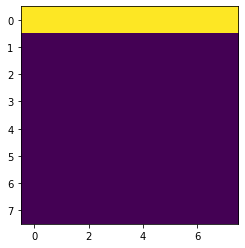

In [64]:
test_top_row = np.zeros([8,8])
test_top_row[0,:] = 1
plt.imshow(test_top_row)

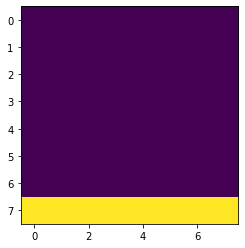

In [65]:
test_bottom_row = np.zeros([8,8])
test_bottom_row[-1,:] = 1
plt.imshow(test_bottom_row)

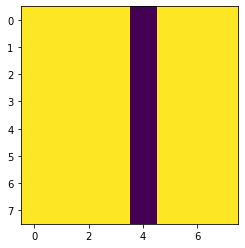

In [66]:
test_vertical_column_disconnect = np.ones([8,8])
test_vertical_column_disconnect[:,4] = 0 
plt.imshow(test_vertical_column_disconnect)

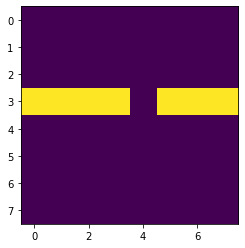

In [67]:
test_row_with_gap = np.zeros([8,8])
test_row_with_gap[3,:] = 1
test_row_with_gap[3,4] = 0 
plt.imshow(test_row_with_gap)

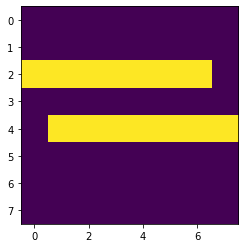

In [68]:
test_two_rows_nearly = np.zeros([8,8])
test_two_rows_nearly[2,:7] = 1
test_two_rows_nearly[4,1:] = 1
plt.imshow(test_two_rows_nearly)

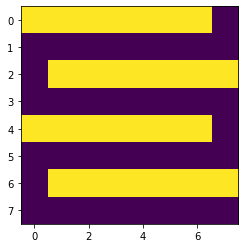

In [69]:
test_four_rows_nearly = np.zeros([8,8])
test_four_rows_nearly[0,:7] = 1
test_four_rows_nearly[2,1:] = 1
test_four_rows_nearly[4,:7] = 1
test_four_rows_nearly[6,1:] = 1
plt.imshow(test_four_rows_nearly)

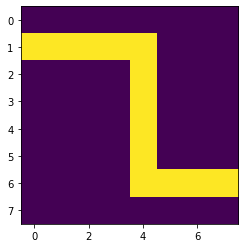

In [70]:
test_dog_leg = np.zeros([8,8])
test_dog_leg[1,:5] = 1
test_dog_leg[2:7,4] = 1
test_dog_leg[6,4:] = 1
plt.imshow(test_dog_leg)

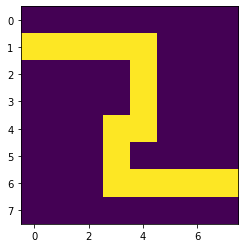

In [71]:
test_dog_leg_back = np.zeros([8,8])
test_dog_leg_back[1,:5] = 1
test_dog_leg_back[2:5,4] = 1
test_dog_leg_back[4:6,3] = 1
test_dog_leg_back[6,3:] = 1
plt.imshow(test_dog_leg_back)

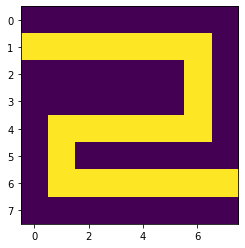

In [72]:
test_long_path = np.zeros([8,8])
test_long_path[1,:7] = 1
test_long_path[2:4,6] = 1
test_long_path[4,1:7] = 1
test_long_path[5:7,1] = 1
test_long_path[6,1:] = 1
plt.imshow(test_long_path)


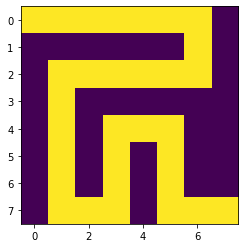

In [73]:
test_longer_path = np.zeros([8,8])
test_longer_path[0,:7] = 1
test_longer_path[1:3,6] = 1
test_longer_path[2,1:7] = 1
test_longer_path[3:8,1] = 1
test_longer_path[7,2:4] = 1
test_longer_path[4:7,3] = 1
test_longer_path[4,4:6] = 1
test_longer_path[5:8,5] = 1
test_longer_path[7,6:8] = 1
plt.imshow(test_longer_path)

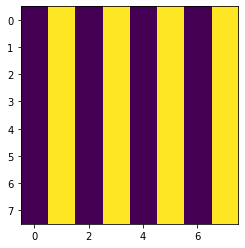

In [74]:
test_vertical_stripes = np.zeros([8,8])
test_vertical_stripes[:,1] = 1
test_vertical_stripes[:,3] = 1
test_vertical_stripes[:,5] = 1
test_vertical_stripes[:,7] = 1
plt.imshow(test_vertical_stripes)

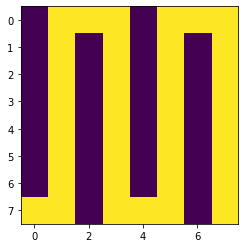

In [75]:
test_vertical_stripes_connected_1 = np.zeros([8,8])
test_vertical_stripes_connected_1[:,1] = 1
test_vertical_stripes_connected_1[:,3] = 1
test_vertical_stripes_connected_1[:,5] = 1
test_vertical_stripes_connected_1[:,7] = 1
test_vertical_stripes_connected_1[7,0] = 1
test_vertical_stripes_connected_1[0,2] = 1
test_vertical_stripes_connected_1[7,4] = 1
test_vertical_stripes_connected_1[0,6] = 1

plt.imshow(test_vertical_stripes_connected_1)

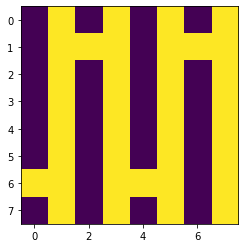

In [76]:
test_vertical_stripes_connected_2 = np.zeros([8,8])
test_vertical_stripes_connected_2[:,1] = 1
test_vertical_stripes_connected_2[:,3] = 1
test_vertical_stripes_connected_2[:,5] = 1
test_vertical_stripes_connected_2[:,7] = 1
test_vertical_stripes_connected_2[6,0] = 1
test_vertical_stripes_connected_2[1,2] = 1
test_vertical_stripes_connected_2[6,4] = 1
test_vertical_stripes_connected_2[1,6] = 1

plt.imshow(test_vertical_stripes_connected_2)

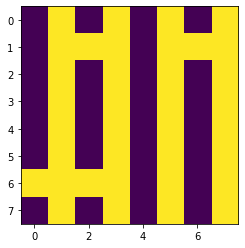

In [77]:
test_vertical_stripes_disconnected_1 = np.zeros([8,8])
test_vertical_stripes_disconnected_1[:,1] = 1
test_vertical_stripes_disconnected_1[:,3] = 1
test_vertical_stripes_disconnected_1[:,5] = 1
test_vertical_stripes_disconnected_1[:,7] = 1
test_vertical_stripes_disconnected_1[6,0] = 1
test_vertical_stripes_disconnected_1[1,2] = 1
test_vertical_stripes_disconnected_1[6,2] = 1
test_vertical_stripes_disconnected_1[1,6] = 1

plt.imshow(test_vertical_stripes_disconnected_1)

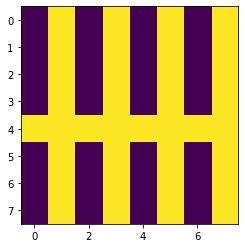

In [78]:
test_vertical_stripes_connected_3 = np.zeros([8,8])
test_vertical_stripes_connected_3[:,1] = 1
test_vertical_stripes_connected_3[:,3] = 1
test_vertical_stripes_connected_3[:,5] = 1
test_vertical_stripes_connected_3[:,7] = 1
test_vertical_stripes_connected_3[4,:] = 1

plt.imshow(test_vertical_stripes_connected_3)

In [79]:
def make_matrices_into_image_training_set( matlist, predicate ):
    """
    This function takes a list of ndarray matrices, and a predicate function which maps each matri
    to a number. 
    
    It returns a [ndata,nrows,ncols,1] numpy tensor with the matrices inserted as images, and a
    [ndata,1] numpy array with the 
    """
    ndata = len(matlist)
    assert ndata >  0 
    
    nrows = matlist[0].shape[0]
    ncols = matlist[0].shape[1]
    data_set = np.zeros([ndata, nrows, ncols, 1])
    data_classes = np.zeros([ndata,1])
    
    for x in range(ndata):
        data_set[x,:,:,0] = matlist[x]
        data_classes[x,0] = predicate(matlist[x])

    return ( data_set, data_classes )

In [80]:
test_data, test_classes = make_matrices_into_image_training_set( [ test_all_zeros, 
                                                                 test_all_ones,
                                                                 test_eye, 
                                                                 test_inverse_eye,
                                                                 test_inverse_eye_connected,
                                                                 test_inverse_eye_connected_bottom,
                                                                 test_inverse_eye_connected_top,
                                                                 test_middle_row, test_top_row, 
                                                                 test_bottom_row, 
                                                                 test_vertical_column_disconnect,
                                                                 test_row_with_gap, 
                                                                 test_two_rows_nearly, 
                                                                 test_four_rows_nearly, 
                                                                 test_dog_leg, 
                                                                 test_dog_leg_back,
                                                                 test_long_path, 
                                                                 test_longer_path, 
                                                                 test_vertical_stripes,
                                                                 test_vertical_stripes_connected_1,
                                                                 test_vertical_stripes_connected_2,
                                                                 test_vertical_stripes_connected_3,
                                                                 test_vertical_stripes_disconnected_1], percolate)

In [81]:
test_data.shape, test_classes.shape

((23, 8, 8, 1), (23, 1))

In [82]:
test_predictions = model.predict( test_data)

In [83]:
np.hstack( [test_classes, test_predictions] ) 

array([[0.        , 0.50113368],
       [1.        , 0.50042856],
       [0.        , 0.50196022],
       [0.        , 0.501903  ],
       [1.        , 0.50175595],
       [1.        , 0.5019055 ],
       [1.        , 0.50182354],
       [1.        , 0.50125021],
       [1.        , 0.50138742],
       [1.        , 0.50160503],
       [0.        , 0.50135642],
       [0.        , 0.5008052 ],
       [0.        , 0.50199449],
       [0.        , 0.502033  ],
       [1.        , 0.50102794],
       [1.        , 0.50178319],
       [1.        , 0.50165886],
       [1.        , 0.50147909],
       [0.        , 0.49985084],
       [1.        , 0.49944118],
       [1.        , 0.49956247],
       [1.        , 0.49919379],
       [0.        , 0.5004192 ]])

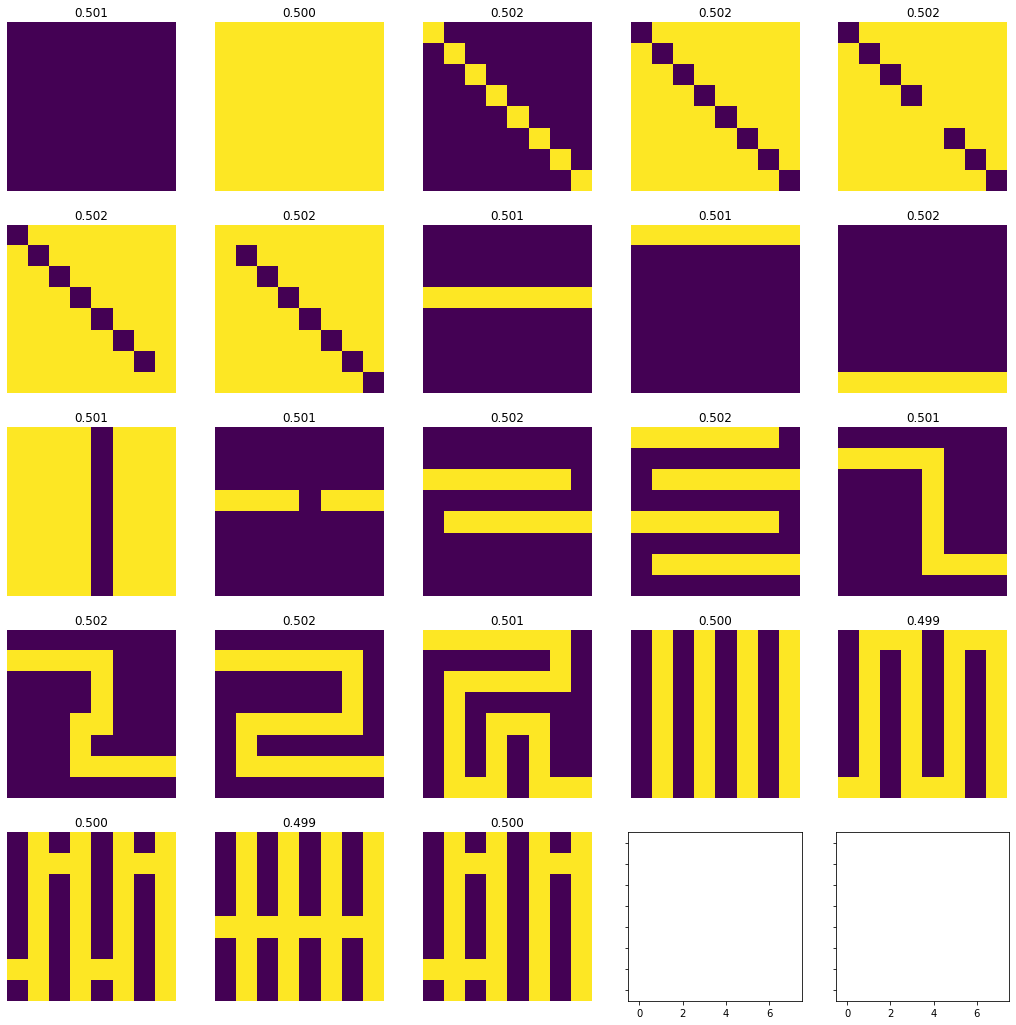

In [84]:
fig,ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(18,18))
ax = ax.flatten()

for i in range(min(25, len(test_predictions) )):
    ax[i].imshow( test_data[ i,:,:,0], vmin=0, vmax=1)
    ax[i].axis('off')
    ax[i].set_title('{:0.3f}'.format(test_predictions[i,0]))